# Calculating weather regimes: a recipe

This recipe requires:
  - A Python environment on any operative system
  - `pandas`, `numpy`, `scikit-learn`
  - `xarray`, `cfgrib` (if the data is in GRIB format), `dask`, `netcdf4`
  - `eofs`
  - Climate data in Grib or NetCDF format

  Source: https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb (28 nov 2023)

## Climate data
I have shared a dataset with daily 500 hPa geopotential height from ERA5 [on a Zenodo repository](https://zenodo.org/record/8384348). 

# The recipe

### 1. Importing modules

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

### 2. Loading the data
The data is loaded from the specified path in a lazy way using `xarray` and `dask`

In [155]:
#PATH = "/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/" 
PATH = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"
# The chunks options *should* improve the performance in opening the files
# filenames = [f"{PATH}zg500_d_ECEarth3_h0{i:02d}.nc" for i in range(10, 17)]

# This one did work, but don't know how to calculate the ceners them? Mean or sum? Produces weird results.
# df = (
#     xr.open_mfdataset(filenames, concat_dim='run', combine="nested",
#                        chunks={'longitude':31, 
#                                'latitude': 16,
#                                'time': -1})
#     .convert_calendar('noleap')
# )

df = (
    xr.open_mfdataset(PATH+'zg500_d_ECEarth3_h021.nc', 
                       chunks={'longitude':31, 
                               'latitude': 16,
                               'time': -1})
    .convert_calendar('noleap')
)

In [156]:
# Doesnt work yet, still double dates in the time dimension. Also seems like a not-so-smart approach.

# def preprocess(ds, run):
#     # Adjust the time values in the dataset
#     ds['time'] = ds['time'] + np.timedelta64(10 * 365 * (run - 10), 'D')
#     return ds

# datasets = [preprocess(xr.open_dataset(filename, chunks={'longitude':31, 'latitude': 16, 'time': -1}), run=i)
#             for i, filename in enumerate(filenames, start=10)]

# df = xr.concat(datasets, dim='time').convert_calendar('noleap')

### 3. Naming your experiment

In [157]:
LABEL = "test_h021zg500_DJF"

### 4. Subsetting data
If you want to compute the clusters only on some months or years. If you have multiple condition in `where` don't forget to add the boolean and `&`. 

In [158]:
df = df.where(
    (df['time'].dt.month.isin([12, 1, 2, 3])) & 
    (df['lon'] < 30) & 
    (df['lat'] > 20) & 
    (df['lat'] < 80), 
    drop=True
)


### 5. Define a function to calculate the anomaly

In [159]:
def calculate_anomaly(da, groupby_type="time.dayofyear"):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

### 6. Calculate the anomaly
Using the function defined in the step 5 applying [`map_blocks`](https://docs.xarray.dev/en/stable/generated/xarray.map_blocks.html)

In [160]:
df_anom = df.map_blocks(calculate_anomaly, template=df.load()) 

### 7. Fixing the date time index
As explained by [this post on StackOverflow](https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime/55787899#55787899
)

In [161]:
df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
df_anom

/tmp/ipykernel_1218587/2841684129.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:    (time: 1210, lon: 171, lat: 85, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T09:00:00 ... 2009-12-31T09:00:00
  * lon        (lon) float64 -90.0 -89.3 -88.59 -87.89 ... 28.12 28.83 29.53
  * lat        (lat) float64 20.7 21.4 22.11 22.81 ... 77.54 78.25 78.95 79.65
    plev       (time) float64 5e+04 5e+04 5e+04 5e+04 ... 5e+04 5e+04 5e+04
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds, time, lat) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat_bnds   (lat, bnds, time, lon) float64 0.0 0.0 ... 1.421e-14 1.421e-14
    zg500      (time, lat, lon) float32 -22.39 -21.74 -20.71 ... -215.2 -214.4

### 8. Defining EOF and clustering parameters
The most important parameters are the number of EOFs to use as K-Means predictors (`n_eofs_for_kmeans`) and how many clusters (`n_clusters`)

In [162]:
use_scaling = 0
n_eofs = 30
n_eofs_for_kmeans = 20 # was 20
n_clusters = 4 # was 4

### 9. Setting up the EOF
Applying a square-root of cosine of latitude weighting (as shown [in this example](https://ajdawson.github.io/eofs/latest/examples/elnino_xarray.html?highlight=coslat))

In [163]:
coslat = np.cos(np.deg2rad(df_anom.coords['lat'].values)).clip(0., 1.) # changed this 'latitude' into 'lat'
wgts   = np.sqrt(coslat)[..., np.newaxis]
# df_anom['zg500'] = df_anom['zg500'].transpose('time', 'run', 'lat', 'lon')
solver = Eof(df_anom['zg500'], weights=wgts)
eofs = solver.eofs(neofs=n_eofs)

### 10. Calculating the EOF
Also saving the explained variance

In [164]:
eofs_corr = solver.eofsAsCorrelation(neofs=n_eofs)
explained_var = solver.varianceFraction()

### 11. Extracting the principal components
Removing also some unneeded coordinates

In [165]:
# pcs = solver.projectField(df_anom['z'] #again changed z into psl
#                           .drop(['dayofyear', 'number', 'step', 'isobaricInhPa']), 
#                           neofs=n_eofs, 
#                           eofscaling=use_scaling)
pcs = solver.projectField(df_anom['zg500'], #again changed z into psl), 
                          neofs=n_eofs, 
                          eofscaling=use_scaling)

### 12. Converting the principal components to a data frame

In [166]:
df_pcs = (pcs
          .to_dataframe()
          .reset_index()
          .pivot(index='time', columns='mode',values='pseudo_pcs')
          .add_prefix('EOF')
         )
df_pcs.index = pd.to_datetime(df_pcs.index)
df_pcs.head()

mode,EOF0,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9,...,EOF20,EOF21,EOF22,EOF23,EOF24,EOF25,EOF26,EOF27,EOF28,EOF29
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:00:00,2646.733398,-1385.829346,519.787720,-5036.938477,1581.223389,-8852.571289,64.705009,-3933.951416,2075.884277,-805.268188,...,756.936462,-432.441650,392.715698,-774.413513,584.855469,-194.195984,826.246216,-323.950928,-164.271149,1092.364990
2000-01-02 09:00:00,423.969971,-2965.397461,-255.037262,-4314.491211,864.424805,-7894.647949,-1981.289551,-4597.319824,2373.318115,882.470154,...,988.105469,-363.543854,-108.645905,-482.355743,519.120544,289.475006,983.122375,-530.850342,258.547607,298.772675
2000-01-03 09:00:00,202.512329,-4430.357422,-186.543320,-4367.388184,1194.127686,-7264.066895,-2811.868896,-3607.867676,1816.355347,155.317398,...,1151.350708,80.726082,-899.098206,-50.214256,220.185913,321.468689,888.389526,-1045.119263,564.057312,-389.250488
2000-01-04 09:00:00,801.557983,-5837.492188,712.683167,-3176.729492,2272.376709,-5113.477051,-3977.350586,-2909.886719,971.963562,-115.681755,...,714.390686,-234.265381,-1252.531494,-135.258255,-201.946228,360.546814,399.112183,-1047.446289,492.727661,-705.488892
2000-01-05 09:00:00,1615.307739,-7428.959473,1949.623535,-763.566772,3249.497803,-1778.885254,-2910.165771,-2223.575684,1509.152954,383.659515,...,-303.178650,390.805878,-1482.149536,525.572876,-102.196045,1050.897095,881.370544,-418.754578,-298.261932,-324.932922


### 13. Fit K-Means
This may take 20-30 seconds.

In [167]:
X_train = df_pcs.iloc[:, 0:n_eofs_for_kmeans].values
km = KMeans(n_clusters=n_clusters, n_init=500, verbose=0, tol=0.000001, max_iter=500, random_state=3)
km.fit(X_train)

KMeans(max_iter=500, n_clusters=4, n_init=500, random_state=3, tol=1e-06)

### 14. Creating a data frame with the labels

In [168]:
clus = pd.DataFrame(
    data=km.labels_, 
    columns=['cluster_id'], 
    index=df_pcs.index).reset_index()
clus.rename(columns={'time': 'date'}, inplace=True)

clus.set_index('date', inplace=True)

### 14a. Inspecting division of clusters (Bram)

(array([374., 252., 289., 295.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

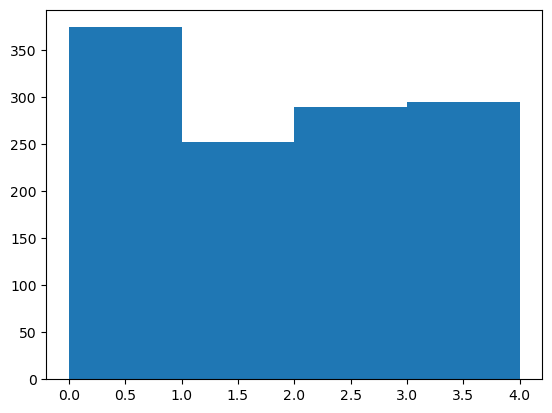

In [169]:
plt.hist(clus['cluster_id'], bins = range(5))

(10957.0, 11381.0)

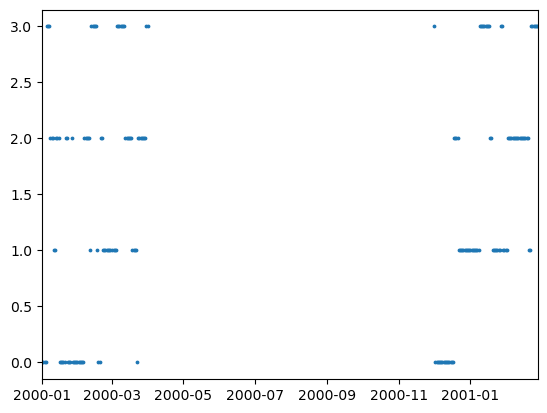

In [170]:
plt.scatter(clus.index, clus['cluster_id'], s = 3)
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2001-2-28'))

In [171]:
from sklearn.metrics import silhouette_score

# Assume 'data' is your dataset and 'labels' are the cluster labels
# In your case, 'labels' would be clus['cluster_id']
labels = clus['cluster_id']

score = silhouette_score(X_train, labels)

print("Silhouette Score: ", score)

Silhouette Score:  0.09885559


### 15. Calculating clusters' center

In [172]:
cluster_centers = pd.DataFrame(
    km.cluster_centers_, 
    columns=[f'eof{i}' for i in np.arange(1,n_eofs_for_kmeans+1)]
    )

### 16. Saving centers to data frame

In [173]:
cluster_center_array = xr.DataArray(
    cluster_centers.values, 
    coords=[np.arange(0, n_clusters), np.arange(0, n_eofs_for_kmeans) ], 
    dims=['centroids', 'mode'])

### 17. Computing the weighted cluster centers in the original space 


In [174]:
eigenvectors20 = eofs.loc[0:n_eofs_for_kmeans, ...]
recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

lons = recons_cluster_centers_weighted.coords['lon'].values 
lats = recons_cluster_centers_weighted.coords['lat'].values

coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)

weights_array = xr.DataArray(wgts, coords=[lats], dims=['lat'])
recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array

### 18. Plot clusters


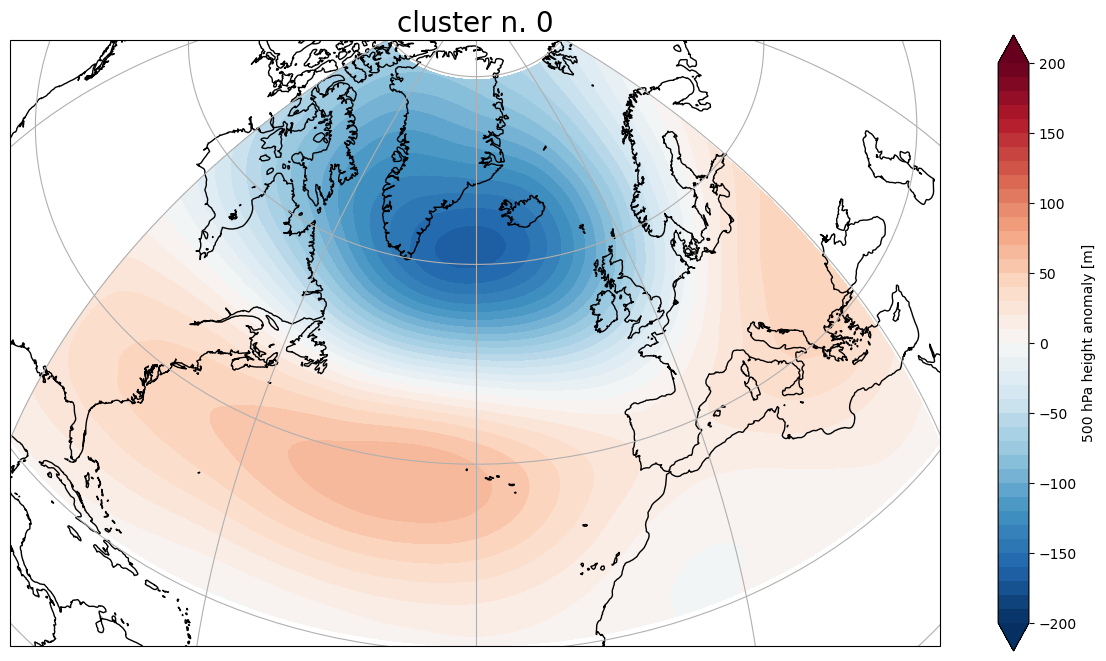

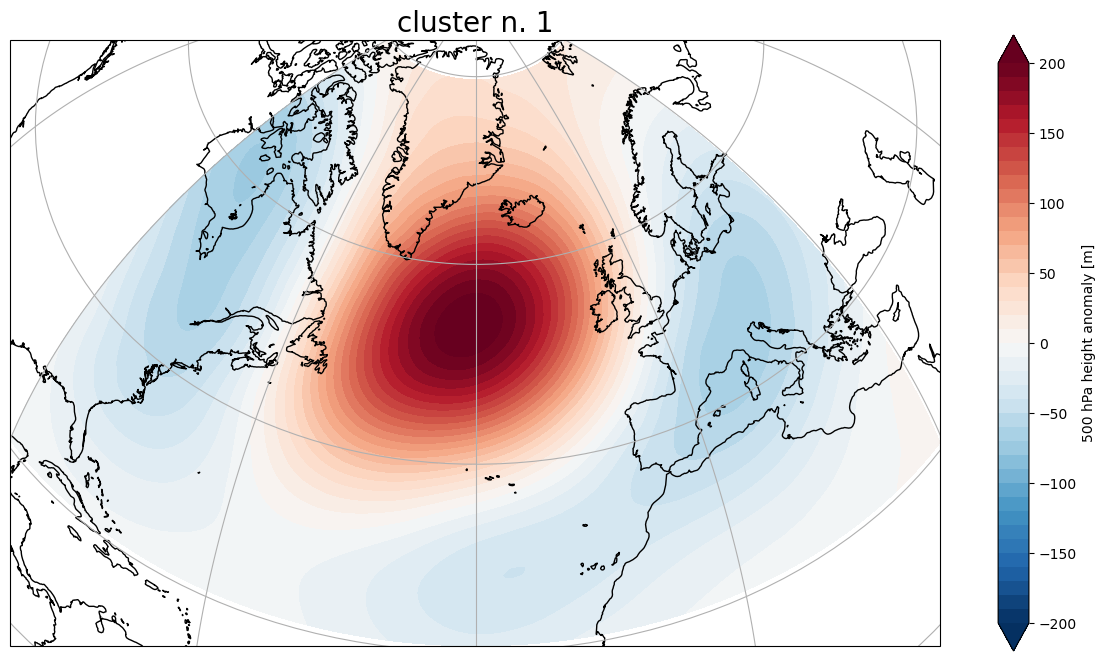

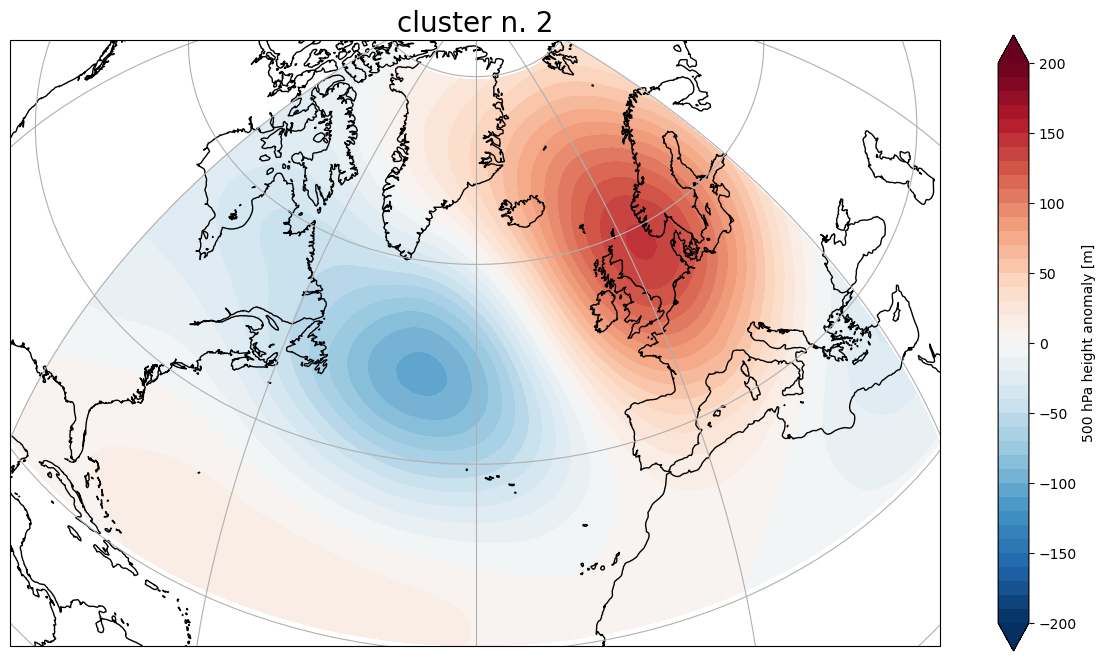

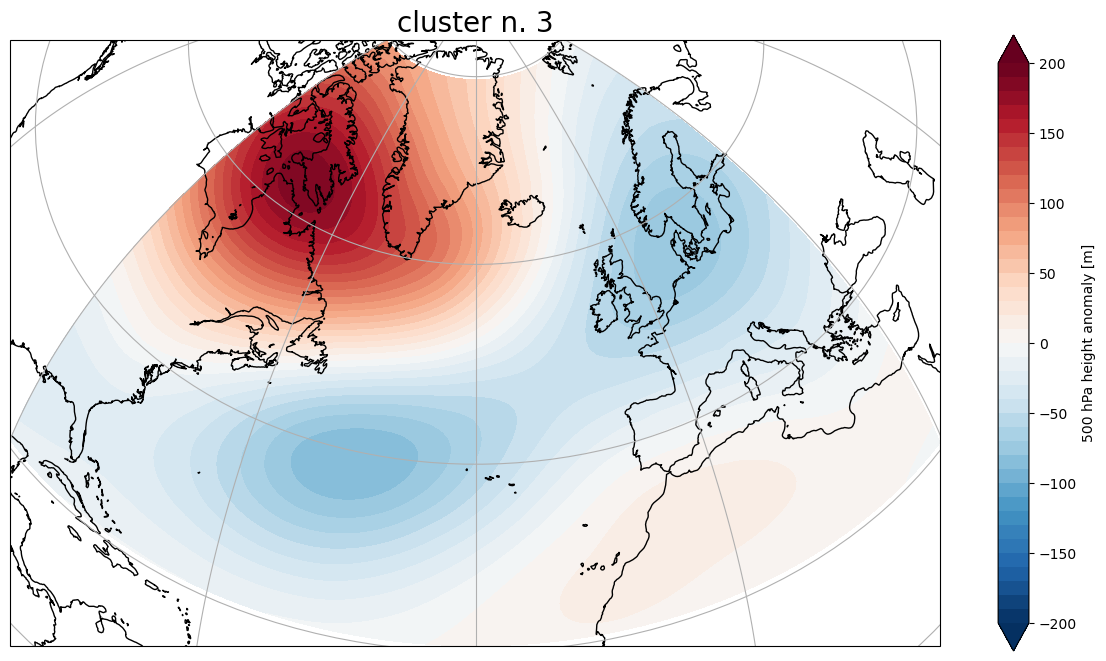

In [175]:
# recons_cluster_centers_unweighted = recons_cluster_centers_unweighted.sum(dim='run')

for i in np.arange(0, n_clusters):

    plt.figure(figsize=(15, 8))
    ax = plt.axes(
        projection=ccrs.Orthographic(central_longitude=-30, central_latitude=50))
    
    vals = recons_cluster_centers_unweighted[i, :, :].squeeze().values

    fill = ax.contourf(
        lons,
        lats,
        recons_cluster_centers_unweighted[i, :, :].squeeze(),
        levels = np.linspace(-200, 200, 41),
        # levels=12,
        # norm=TwoSlopeNorm(
            #vmin=np.nanmin(vals[~np.isinf(vals)]),
            # vmin = -150,
            # vcenter=0,
            # vmax = 150),
            #vmax=np.nanmax(vals[~np.isinf(vals)])),
        cmap=plt.cm.RdBu_r,
        extend = 'both',
        transform=ccrs.PlateCarree())

    cb = plt.colorbar(fill,
                      orientation='vertical',
                      label='500 hPa height anomaly [m]',
                      extend='both')
    # title = f'cluster center: {cluster_index_to_regi    me(i)}'
    title = f'cluster n. {i}'
    ax.coastlines(resolution='50m')
    ax.gridlines()
    
    plt.title(title, fontsize=20)
    plt.show()

### 19. Calculate correlation between sample and assigned regime centroid

In [176]:
# Assume 'kmeans' is your trained KMeans model and 'data' is your dataset
cluster_centers = km.cluster_centers_

# Get the cluster assignment for each sample
labels = km.labels_

# Initialize an empty list to store the correlation coefficients
correlation_coefficients = []

# For each sample, calculate the Pearson correlation coefficient with its assigned cluster center
for i in tqdm(range(len(X_train))):
    corr, _ = pearsonr(X_train[i], cluster_centers[labels[i]])
    correlation_coefficients.append(corr)

  0%|          | 0/1210 [00:00<?, ?it/s]

In [177]:
#add the correlation coefficients to the dataframe
clus['centroid_similarity'] = correlation_coefficients

In [178]:
clus

,cluster_id,centroid_similarity
date,,
2000-01-01 09:00:00,0,0.334728
2000-01-02 09:00:00,0,0.194373
2000-01-03 09:00:00,0,0.205517
2000-01-04 09:00:00,0,0.232288
2000-01-05 09:00:00,3,0.242921
...,...,...
2009-12-27 09:00:00,3,0.661693
2009-12-28 09:00:00,3,0.528254
2009-12-29 09:00:00,3,0.381475
